In [1]:
import utils
import cv2 as cv
import numpy as np
import argparse
import os
import torch as torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from model import SpeedDetector
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split
import pickle

In [2]:
class DashCamDataset(Dataset):
    
    def normalize(self, arr, return_scaler=True, scalerfile='../data/scalers/scaler.sav'):
        scaler = StandardScaler()
        normed = scaler.fit_transform(arr.reshape(-1, 1))
        
        # save scaler
        pickle.dump(scaler, open(scalerfile, 'wb'))
        
        if return_scaler:
            return normed, scaler
        else:
            return normed   

    def frames_to_numpy(self, path):
        data = {}
        print('Loading frames and labels...')
        for i, filename in tqdm(enumerate(os.listdir(path))):
            if filename.endswith(".jpg"):
                img = cv.imread(path+filename)
                data[i] = img
                continue
            else:
                continue
        return data

    def __init__(self, video_path, labels_path, transform=None, target_transform=None):
        self.frame_labels = pd.read_csv(labels_path)
        self.frame_labels.columns = ['speed']
        self.transform = transform
        self.target_transform = target_transform
        
        if self.target_transform == 'norm':
            self.y, self.scaler = self.normalize(self.frame_labels.speed.values)
        elif self.target_transform == None:
            self.y = self.frame_labels.speed.values.reshape(-1, 1)
        
        if video_path.endswith('/') == False:
            print('Reading video and computing optical flow...')
            utils.video_to_optical_flow_frames(video_path, 'data/rgb/')
            self.x = self.frames_to_numpy(video_path)
        else:
            self.x = self.frames_to_numpy(video_path)

        if len(self.x) != len(self.y):
            print(f'X ({len(self.x)}) and y ({len(self.y)}) are misaligned')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.Tensor(label)

        sample = {"image": image, "label": label}
        
        return sample

In [3]:
frames_path = '../data/rgb/'
video_path = '../data/raw_video/train.mp4'
labels_path = '../data/labels/train.txt'
batch_size = 128

In [4]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((150, 480)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(),
    transforms.ToTensor(),
#     transforms.Grayscale(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

In [5]:
dataset = DashCamDataset(
    frames_path,
    labels_path, 
    transform=image_transforms,
    target_transform='norm'
)

6it [00:00, 56.53it/s]

Loading frames and labels...


20399it [02:39, 128.00it/s]


In [6]:
class SpeedDetector(nn.Module):
        def __init__(self, hidden_size):
                super().__init__()

                self.hidden_size = hidden_size
                self.conv1 = nn.Conv2d(3, 6, 3)
                self.norm1 = nn.BatchNorm2d(6)
                
                self.conv2 = nn.Conv2d(6, 12, 8)
                self.norm2 = nn.BatchNorm2d(12)

                self.conv3 = nn.Conv2d(12, 24, 7)
                self.norm3 = nn.BatchNorm2d(24)

                self.conv4 = nn.Conv2d(24, 36, 4)
                self.norm4 = nn.BatchNorm2d(36)
                
                self.relu = nn.ReLU()
                self.pool = nn.AvgPool2d(2)
                self.dropout = nn.Dropout(0.5)

                self.fc1 = nn.Linear(4680, self.hidden_size)
                self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
                self.fc3 = nn.Linear(self.hidden_size, 1)

        def forward(self, x):
                
                # Convolution layers
                # print(x.shape)
                x = self.relu(self.pool(self.norm1(self.conv1(x))))
                # print(x.shape)

                x = self.relu(self.pool(self.norm2(self.conv2(x))))
                # print(x.shape)

                x = self.relu(self.pool(self.norm3(self.conv3(x))))
                # print(x.shape)

                x = self.relu(self.pool(self.norm4(self.conv4(x))))
                # print(x.shape)

                # fully connected layers
                x = x.view(x.size(0), -1)
                # print(x.shape)
                
                x = self.dropout(x)
                x = self.relu(self.fc1(x))
                # print(x.shape)

                x = self.dropout(x)
                x = self.fc2(x)
                # print(x.shape)

                x = self.dropout(x)
                x = self.fc3(x)
                # print(x.shape)
                return x

        def predict(self, image):
                self.eval()
                with torch.no_grad():
                        prediction = self.forward(image)
                return prediction
        
        def save_checkpoint(self, epoch, optimizer, loss, f_path):
                torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss
                        }, f_path)
                
        def load_checkpoint(self, checkpoint_path, model, optimizer):
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                return model, optimizer

In [7]:
# Train / Validation split
split = 0.8
train_len = int(len(dataset)*split)
lengths = [train_len, len(dataset)-train_len]

trainset, validset = random_split(dataset, lengths)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
model_path = None # 'models/model_normed.pt'

if model_path != None:
    model = SpeedDetector().to(device)   
    model.load_state_dict(torch.load(model_path))
else:
    model = SpeedDetector().to(device)
    
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [56]:
# sample = next(iter(trainloader))
# model(sample['image'].to(device))

# print(model)
# n_epochs = 100
# for epoch in range(n_epochs):
#     # Train
#     train_loss = 0.0
#     model.train()
#     for batch_idx, batch in tqdm(enumerate([sample])):
#         image, label = batch['image'].to(device), batch['label'].to(device)

#         optimizer.zero_grad()
#         output = model(image)
#         loss = criterion(output, label)

#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#     train_loss = train_loss / len(trainloader)
#     print(train_loss)
#     # Validate
#     valid_loss = 0.0
#     model.eval()
#     for batch_idx, batch in tqdm(enumerate([next(iter(validloader))])):

#         with torch.no_grad():
#             image, label = batch['image'].to(device), batch['label'].to(device)

#             output = model(image)
#             error = criterion(output, label)

#             valid_loss += error.item()
#     valid_loss = valid_loss / len(validloader)
    
#     print(f'{epoch} - train: {train_loss}, valid: {valid_loss}')

1it [00:00, 15.61it/s]
1it [00:00, 16.93it/s]
1it [00:00, 17.23it/s]

SpeedDetector(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(6, 12, kernel_size=(6, 6), stride=(1, 1))
  (norm3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(12, 24, kernel_size=(12, 12), stride=(1, 1))
  (norm4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1056, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
0.008501577191054821
0.008437849581241608



1it [00:00, 17.84it/s]
1it [00:00, 18.23it/s]
1it [00:00, 18.17it/s]
0it [00:00, ?it/s]

0.008106360211968422
0.008084114640951157
0.008125260472297668
0.007780455052852631


1it [00:00, 17.23it/s]
1it [00:00, 18.50it/s]
1it [00:00, 17.84it/s]
1it [00:00, 14.27it/s]

0.008070340380072594
0.008074904792010784
0.007431154139339924



1it [00:00, 14.69it/s]
1it [00:00, 14.27it/s]
1it [00:00, 17.84it/s]

0.007458917796611786
0.007491227239370346
0.007779756095260382



1it [00:00, 17.53it/s]
1it [00:00, 17.84it/s]
1it [00:00, 17.53it/s]
0it [00:00, ?it/s]

0.0075971586629748344
0.007310889661312103
0.0077268583700060844
0.007542290724813938


1it [00:00, 17.24it/s]
1it [00:00, 18.47it/s]
1it [00:00, 18.17it/s]
1it [00:00, 18.19it/s]
0it [00:00, ?it/s]

0.007436519023030996
0.00742451474070549
0.007667801342904568
0.007305796258151531


1it [00:00, 16.93it/s]
1it [00:00, 18.20it/s]
1it [00:00, 15.21it/s]
0it [00:00, ?it/s]

0.007477059960365295
0.0075114136561751366
0.0068633644841611385


1it [00:00, 14.48it/s]
1it [00:00, 14.69it/s]
1it [00:00, 15.61it/s]
1it [00:00, 18.17it/s]

0.00720730796456337
0.006880225148051977
0.007147578522562981



1it [00:00, 18.17it/s]
1it [00:00, 18.50it/s]
1it [00:00, 18.17it/s]
0it [00:00, ?it/s]

0.006579422391951084
0.006440358702093363
0.007016145624220371
0.006462902761995792


1it [00:00, 17.53it/s]
1it [00:00, 18.17it/s]
1it [00:00, 18.17it/s]
1it [00:00, 18.50it/s]
0it [00:00, ?it/s]

0.006913147866725922
0.0064786518923938274
0.006495567969977856
0.006446392275393009


1it [00:00, 17.23it/s]
1it [00:00, 18.17it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.23it/s]
0it [00:00, ?it/s]

0.005913798697292805
0.00656873919069767
0.005928583908826113
0.005989772733300924


1it [00:00, 16.11it/s]
1it [00:00, 14.48it/s]
1it [00:00, 16.11it/s]
0it [00:00, ?it/s]

0.006616238504648209
0.005155895836651325
0.005819851532578468


1it [00:00, 16.38it/s]
1it [00:00, 16.93it/s]
1it [00:00, 16.93it/s]
1it [00:00, 16.93it/s]
0it [00:00, ?it/s]

0.005703224800527096
0.0054682036861777306
0.005730642005801201
0.0056503769010305405


1it [00:00, 16.93it/s]
1it [00:00, 16.65it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.53it/s]
0it [00:00, ?it/s]

0.005462569184601307
0.005660955794155598
0.005076011177152395
0.005647382698953152


1it [00:00, 17.23it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.53it/s]
1it [00:00, 17.23it/s]


0.005681929178535938
0.004493255168199539
0.004130581859499216
0.005098074674606323


1it [00:00, 17.53it/s]
1it [00:00, 16.93it/s]
1it [00:00, 16.38it/s]
1it [00:00, 17.23it/s]

0.0046468693763017654
0.004067443311214447
0.004190250299870968



1it [00:00, 17.23it/s]
1it [00:00, 17.23it/s]
1it [00:00, 18.16it/s]
0it [00:00, ?it/s]

0.00477440282702446
0.004081162624061108
0.004850286524742842
0.004218047484755516


1it [00:00, 16.11it/s]
1it [00:00, 17.53it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.23it/s]
0it [00:00, ?it/s]

0.00406978465616703
0.004503511358052492
0.0043795425444841385
0.0041824388317763805


1it [00:00, 17.08it/s]
1it [00:00, 16.65it/s]
1it [00:00, 16.93it/s]
0it [00:00, ?it/s]

0.004071229137480259
0.004582011606544256
0.0038928152061998844


1it [00:00, 16.93it/s]
1it [00:00, 17.23it/s]
1it [00:00, 14.48it/s]
1it [00:00, 16.11it/s]

0.0036511155776679516
0.0035671545192599297
0.003894431982189417



1it [00:00, 16.11it/s]
1it [00:00, 15.86it/s]
1it [00:00, 16.93it/s]

0.003752483520656824
0.0036223542410880327
0.003553854301571846



1it [00:00, 17.23it/s]
1it [00:00, 16.38it/s]
1it [00:00, 17.53it/s]
0it [00:00, ?it/s]

0.0036905803717672825
0.0034346170723438263
0.0029208241030573845
0.003211179981008172


1it [00:00, 16.11it/s]
1it [00:00, 17.84it/s]
1it [00:00, 17.23it/s]
1it [00:00, 17.53it/s]
0it [00:00, ?it/s]

0.0033195384312421083
0.0032673447858542204
0.003415676299482584
0.003261398058384657


1it [00:00, 16.93it/s]
1it [00:00, 16.65it/s]
1it [00:00, 15.37it/s]
0it [00:00, ?it/s]

0.0034121861681342125
0.002982705133035779
0.003194398246705532


1it [00:00, 14.48it/s]
1it [00:00, 15.37it/s]
1it [00:00, 15.61it/s]
0it [00:00, ?it/s]

0.0030385456047952175
0.0029493600595742464
0.0028160936199128628


1it [00:00, 15.37it/s]
1it [00:00, 16.38it/s]
1it [00:00, 16.11it/s]
1it [00:00, 15.86it/s]

0.0031660187523812056
0.002369875553995371
0.0029523707926273346



1it [00:00, 16.38it/s]
1it [00:00, 16.93it/s]
1it [00:00, 17.23it/s]

0.002942994236946106
0.003437679260969162
0.00308847613632679



1it [00:00, 18.17it/s]
1it [00:00, 17.53it/s]
1it [00:00, 14.48it/s]

0.0022992235608398914
0.002136324066668749
0.0022381048183888197



1it [00:00, 14.48it/s]
1it [00:00, 16.38it/s]
1it [00:00, 13.50it/s]

0.0028029445093125105
0.0024395370855927467
0.0022879326716065407
0.0028521220665425062


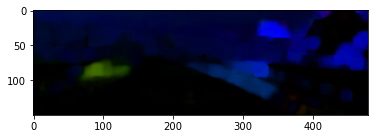

In [15]:
import matplotlib.pyplot as plt
sample = next(iter(validloader))
plt.imshow(transforms.ToPILImage()(sample['image'][0]))
plt.show()

In [16]:
checkpoint = torch.load('../checkpoints/checkpoint.pt')
loaded_model = SpeedDetector(hidden_size=64)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.cpu().eval()

SpeedDetector(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(8, 8), stride=(1, 1))
  (norm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(7, 7), stride=(1, 1))
  (norm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1))
  (norm4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4680, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
predictions_ = pd.DataFrame([        
    sample['label'].view(1, -1).numpy()[0],
    loaded_model.predict(sample['image'].cpu()).view(1, -1).numpy()[0]
], index=['t', 'p'])

<AxesSubplot:>

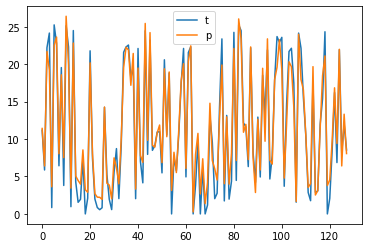

In [18]:
predictions = pd.DataFrame(dataset.scaler.inverse_transform(predictions_),
                          index=['t', 'p']).T
predictions.plot()

In [13]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(predictions.t, predictions.p) ** 0.5

In [20]:
labels = pd.read_csv('../data/labels/train.txt')

In [32]:
labels.values[0]

array([28.105569])

In [ ]:
predictions = []
for i, filename in tqdm(enumerate(os.listdir(frames_path))):
    if filename.endswith(".jpg"):
        img = cv.imread(frames_path+filename)
        rgb = image_transforms(img)
        p = loaded_model.predict(rgb.unsqueeze(0))
        p_ = dataset.scaler.inverse_transform(p)[0]
        predictions.append(p_)
        print(p_, labels.values[i])
        cv.imshow('img', img)q

7it [00:00, 67.25it/s]

[15.128569] [28.105569]
[8.08445] [28.106527]
[10.31377] [28.130404]
[15.157763] [28.109243]
[14.315247] [28.088572]
[14.2374935] [28.034211]
[15.04752] [28.018491]
[19.523945] [27.986624]
[22.645071] [28.016352]
[22.796406] [27.981986]
[24.451565] [27.978625]
[21.636374] [28.032331]
[22.2797] [27.960219]
[21.980164] [27.937178]
[23.971113] [27.940599]
[15.951873] [27.908579]
[24.256617] [27.898606]
[25.477442] [27.855982]


35it [00:00, 121.20it/s]

[24.201492] [27.795581]
[23.132774] [27.850634]
[24.200912] [27.839349]
[24.198072] [27.824348]
[25.498602] [27.759608]
[27.193314] [27.830055]
[24.32922] [27.761886]
[24.955305] [27.694763]
[18.381838] [27.761203]
[25.566355] [27.691932]
[24.351341] [27.666086]
[25.5532] [27.723912]
[26.856682] [27.639469]
[25.976229] [27.612874]
[27.921495] [27.638534]
[22.919333] [27.606098]
[27.195576] [27.593209]
[24.94813] [27.573926]
[26.8373] [27.561151]
[18.860739] [27.559232]
[26.213667] [27.528067]
[24.597998] [27.522542]
[25.568478] [27.531058]
[27.722277] [27.493015]
[26.374006] [27.487706]


61it [00:00, 125.58it/s]

[26.88736] [27.440943]
[25.030813] [27.439646]
[26.871456] [27.412907]
[26.58852] [27.401744]
[24.710985] [27.396007]
[19.389587] [27.35751]
[24.149033] [27.365647]
[22.83421] [27.347638]
[23.13145] [27.302128]
[23.919107] [27.309836]
[23.301266] [27.266277]
[25.785658] [27.266066]
[25.588224] [27.238097]
[24.714205] [27.239031]
[25.545427] [27.227439]
[25.767738] [27.209839]
[18.479425] [27.224821]
[24.311829] [27.181666]
[25.116928] [27.170096]
[23.479498] [27.15459]
[24.073467] [27.104113]
[24.053402] [27.081358]
[24.169527] [27.071874]
[27.070105] [27.073267]


89it [00:00, 132.30it/s]

[25.020197] [27.039336]
[20.506735] [27.041493]
[23.273167] [27.018145]
[14.76192] [27.009551]
[23.14234] [26.996247]
[21.702032] [26.954839]
[21.680838] [26.968576]
[23.716747] [26.913075]
[24.934553] [26.903469]
[22.051098] [26.908829]
[23.668419] [26.860309]
[22.686758] [26.86931]
[23.216139] [26.870268]
[21.918947] [26.836196]
[19.2621] [26.836415]
[22.215065] [26.843831]
[22.837154] [26.775542]
[24.118155] [26.732431]
[24.31698] [26.730095]
[22.602667] [26.73078]
[23.896353] [26.708966]
[23.431725] [26.692341]
[24.262247] [26.690703]
[23.068316] [26.646072]
[21.383337] [26.644104]
[16.5429] [26.627146]


117it [00:00, 134.42it/s]

[24.769775] [26.569781]
[23.102364] [26.564525]
[19.857111] [26.577363]
[24.095049] [26.535204]
[23.319656] [26.541647]
[24.622856] [26.529513]
[25.975338] [26.501939]
[22.232328] [26.50846]
[22.79294] [26.456369]
[22.878654] [26.460903]
[19.221834] [26.447106]
[24.373156] [26.444679]
[23.540422] [26.432169]
[25.01008] [26.348981]
[24.80883] [26.368428]
[24.344946] [26.328696]
[24.353437] [26.287243]
[23.303005] [26.286672]
[25.16988] [26.273133]
[26.282675] [26.258781]
[25.9629] [26.26402]
[13.9713955] [26.216485]
[14.515723] [26.229105]
[24.628712] [26.205432]
[26.122452] [26.184952]
[24.443861] [26.187712]


131it [00:01, 132.06it/s]

[24.769537] [26.163657]
[25.092093] [26.115078]
[26.04625] [26.115793]
[23.95954] [26.106916]
[25.810434] [26.093713]
[24.52699] [26.026723]
[23.989038] [26.059682]
[18.443317] [26.043513]
[20.594809] [26.026975]
[23.628828] [26.036413]
[23.341436] [25.985965]
[24.346096] [25.882752]
[23.532257] [25.848527]
[24.46401] [25.92309]
[23.148544] [25.898218]
[25.569494] [25.936657]
[24.080177] [25.889446]
[25.183634] [25.881018]
[18.715763] [25.883611]
[26.23451] [25.838685]
[24.89693] [25.837266]
[23.919056] [25.76013]
[25.954338] [25.72661]


159it [00:01, 129.54it/s]

[26.301407] [25.705029]
[26.645735] [25.69282]
[24.902723] [25.694555]
[24.52532] [25.715744]
[25.276129] [25.721072]
[24.7891] [25.71009]
[20.820086] [25.675076]
[24.7961] [25.690365]
[24.742983] [25.659273]
[22.806713] [25.588452]
[24.00926] [25.587607]
[26.859356] [25.605106]
[26.060093] [25.546981]
[23.603619] [25.561611]
[24.456743] [25.520048]
[24.732208] [25.512851]
[24.151423] [25.535949]
[19.184675] [25.466815]
[24.609749] [25.468195]
[22.333479] [25.442955]
[24.501125] [25.43467]
[24.35892] [25.415651]
[22.055717] [25.376169]
[22.269955] [25.380297]


186it [00:01, 131.20it/s]

[23.724472] [25.31671]
[22.362564] [25.308004]
[23.365938] [25.307879]
[23.176418] [25.25791]
[16.98213] [25.234153]
[20.90404] [25.234548]
[23.0883] [25.16456]
[24.14553] [25.155528]
[24.03743] [25.124563]
[21.220327] [25.05188]
[24.29818] [25.069608]
[23.745945] [24.984767]
[24.002962] [24.967705]
[22.214035] [24.989188]
[24.112484] [24.92012]
[21.631329] [24.878731]
[23.654915] [24.78153]
[23.52416] [24.813369]
[24.25035] [24.765025]
[25.463306] [24.703236]
[19.581923] [24.719001]
[25.953089] [24.616928]
[22.170458] [24.599527]
[22.485107] [24.583681]
[25.27733] [24.478286]


214it [00:01, 132.42it/s]

[22.124887] [24.44661]
[20.297235] [24.425899]
[21.513838] [24.334192]
[19.59746] [24.277394]
[23.329348] [24.243752]
[22.68145] [24.166103]
[22.868874] [24.169954]
[22.269186] [24.066184]
[23.133175] [24.031755]
[22.638327] [24.00579]
[22.989283] [23.927473]
[23.110346] [23.890764]
[18.635498] [23.798889]
[21.36356] [23.841604]
[22.699888] [23.759881]
[23.304115] [23.71539]
[22.806637] [23.748295]
[21.504663] [23.647204]
[22.444672] [23.596707]
[22.91076] [23.584715]
[22.458244] [23.55405]
[21.114151] [23.472504]
[23.679657] [23.504016]
[16.54687] [23.379037]
[22.119808] [23.358512]


228it [00:01, 130.78it/s]

[23.038954] [23.260696]
[21.231834] [23.247885]
[24.08863] [23.215724]
[20.792532] [23.145633]
[23.272072] [23.102612]
[21.584425] [23.045069]
[24.661942] [23.051338]
[21.873869] [23.015295]
[21.415976] [22.881877]
[14.229634] [22.915834]
[15.348648] [22.857471]
[23.46404] [22.757829]
[21.552298] [22.801015]
[20.530415] [22.703557]
[22.032974] [22.632107]
[22.008045] [22.650746]
[21.848318] [22.539414]
[20.793213] [22.495062]
[21.812979] [22.497131]
[22.928507] [22.412535]
[20.341496] [22.305346]
[16.04149] [22.266352]
[20.538801] [22.274608]
[20.969687] [22.213149]


256it [00:01, 131.20it/s]

[21.717957] [22.111782]
[21.947119] [22.098621]
[20.578568] [22.023265]
[21.143404] [21.9876]
[20.837908] [21.96738]
[21.35835] [21.867499]
[22.511831] [21.878563]
[18.85167] [21.830777]
[16.568806] [21.724761]
[19.71868] [21.720484]
[21.139866] [21.682866]
[21.367739] [21.565654]
[20.550158] [21.630614]
[19.830338] [21.522918]
[21.484913] [21.49305]
[19.190449] [21.502722]
[19.744984] [21.393423]
[22.639292] [21.312005]
[19.92127] [21.256784]
[15.057231] [21.283194]
[20.903334] [21.170907]
[21.091326] [21.128252]
[20.662775] [21.108952]
[22.71171] [21.026714]
[19.165594] [20.997039]


284it [00:02, 132.16it/s]

[23.064186] [21.006357]
[21.523586] [20.969367]
[19.629362] [20.944717]
[19.92099] [20.942738]
[18.65546] [20.863276]
[17.410637] [20.872582]
[18.081207] [20.858857]
[19.677795] [20.820238]
[18.237892] [20.823964]
[19.646212] [20.751848]
[18.900982] [20.723851]
[20.108438] [20.729127]
[16.63357] [20.679543]
[19.09481] [20.582223]
[16.313309] [20.543176]
[20.868443] [20.562831]
[16.656378] [20.485892]
[18.432549] [20.365818]
[20.327946] [20.3791]
[19.915792] [20.319317]
[18.51627] [20.222046]
[20.196676] [20.281935]
[20.00779] [20.160613]
[20.078999] [20.137914]
[19.122536] [20.138333]


312it [00:02, 133.84it/s]

[19.44247] [20.02506]
[17.659512] [19.992256]
[14.587908] [19.911347]
[18.433416] [19.882995]
[18.049425] [19.877321]
[18.532526] [19.715738]
[17.956715] [19.649489]
[17.291311] [19.60541]
[17.770033] [19.547851]
[17.517763] [19.452522]
[17.939955] [19.356058]
[16.398281] [19.341933]
[15.949743] [19.290832]
[16.815197] [19.110332]
[18.06666] [19.19085]
[15.079645] [19.113866]
[17.477201] [19.037851]
[17.532764] [18.990706]
[17.510942] [18.896681]
[17.407202] [18.732623]
[17.74802] [18.742782]
[17.642733] [18.593645]
[19.465494] [18.517665]
[20.570198] [18.425153]
[16.233866] [18.414805]


340it [00:02, 135.73it/s]

[17.237417] [18.345416]
[17.13226] [18.296095]
[16.48879] [18.280873]
[15.7382] [18.215723]
[18.874723] [18.199875]
[18.836243] [18.170798]
[19.692421] [18.120178]
[18.216122] [18.114072]
[20.249681] [18.101441]
[19.639439] [18.026191]
[17.841854] [18.033098]
[17.9964] [17.985449]
[18.84431] [17.974486]
[18.387875] [17.978176]
[18.518686] [17.926244]
[18.928827] [17.895649]
[18.832243] [17.904253]
[19.544436] [17.900632]
[18.013802] [17.870866]
[17.965746] [17.906272]
[17.265934] [17.91078]
[14.749348] [17.885157]
[16.136988] [17.870561]
[18.192982] [17.859622]
[16.725006] [17.83511]
[18.284399] [17.82089]


354it [00:02, 136.87it/s]

[18.119665] [17.817578]
[17.911045] [17.776329]
[17.814894] [17.773368]
[17.93351] [17.756399]
[19.665255] [17.740411]
[17.921282] [17.750502]
[17.721558] [17.713229]
[18.091967] [17.720286]
[17.879179] [17.707938]
[16.745539] [17.701258]
[17.965252] [17.701865]
[19.258137] [17.694371]
[19.390736] [17.632586]
[18.29253] [17.586225]
[19.31913] [17.526406]
[18.940495] [17.544085]
[19.244633] [17.502712]
[17.613745] [17.451329]
[16.023434] [17.48443]
[18.339434] [17.416052]
[17.812067] [17.388921]
[17.675192] [17.397132]
[17.981358] [17.321062]
[18.14876] [17.293555]
[20.049416] [17.280179]


382it [00:02, 134.74it/s]

[16.473913] [17.215]
[18.145319] [17.198205]
[18.679482] [17.177024]
[18.293032] [17.144791]
[17.755548] [17.13578]
[15.603649] [17.106082]
[19.646694] [17.040895]
[18.217817] [17.066623]
[16.642572] [17.007221]
[17.20708] [16.965812]
[16.760612] [16.902998]
[16.379898] [16.927943]
[16.487509] [16.876896]
[14.974246] [16.82764]
[17.682798] [16.852029]
[15.173395] [16.776187]
[18.336445] [16.727212]
[17.436129] [16.748829]
[14.696564] [16.660815]
[15.897408] [16.658419]
[16.812073] [16.651665]
[16.754248] [16.622098]
[17.117445] [16.596606]
[16.4616] [16.54733]
[13.36499] [16.525286]
[15.781901] [16.507766]


411it [00:03, 136.79it/s]

[15.680966] [16.454513]
[16.671816] [16.436982]
[16.677914] [16.428845]
[15.781725] [16.363859]
[17.340601] [16.348094]
[14.355638] [16.282683]
[17.528202] [16.296509]
[17.514486] [16.271328]
[17.726189] [16.174741]
[16.182646] [16.214317]
[17.534988] [16.157124]
[15.370034] [16.102732]
[15.1714325] [16.106655]
[15.154423] [16.086453]
[14.760566] [16.049456]
[15.663319] [16.051216]
[16.248682] [16.007865]
[16.837296] [15.951593]
[15.91398] [15.894406]
[16.763557] [15.883973]
[17.945448] [15.869272]
[15.192306] [15.811602]
[13.063173] [15.794933]
[16.76781] [15.745741]
[16.443693] [15.726425]
[17.527533] [15.720598]


439it [00:03, 136.29it/s]

[16.685183] [15.675835]
[16.404606] [15.673611]
[14.795678] [15.655756]
[14.391898] [15.627181]
[14.64669] [15.646816]
[13.004111] [15.602119]
[16.634125] [15.579875]
[15.408705] [15.594948]
[17.194136] [15.577295]
[16.77438] [15.555608]
[15.808944] [15.61862]
[16.38289] [15.596103]
[16.248804] [15.598693]
[15.194516] [15.638159]
[13.921663] [15.65641]
[15.219929] [15.578146]
[14.659771] [15.531089]
[14.510424] [15.530522]
[16.260721] [15.542079]
[16.297455] [15.542342]
[15.850226] [15.529362]
[14.313296] [15.544828]
[16.00881] [15.548348]
[16.65966] [15.545864]
[17.889463] [15.558583]


468it [00:03, 138.42it/s]

[17.017916] [15.567834]
[17.375982] [15.552205]
[17.305532] [15.617641]
[18.174353] [15.614487]
[16.802593] [15.604403]
[15.074062] [15.64943]
[17.806274] [15.630264]
[15.859858] [15.649289]
[15.813859] [15.701191]
[13.381197] [15.705422]
[14.523827] [15.687132]
[13.838956] [15.726955]
[16.245213] [15.757108]
[17.221983] [15.768657]
[14.258994] [15.780862]
[17.793003] [15.830419]
[14.991132] [15.82317]
[15.397389] [15.838748]
[15.748482] [15.875624]
[17.268648] [15.868013]
[15.407713] [15.929014]
[15.299853] [15.93642]
[17.394417] [15.963043]
[17.7485] [15.997256]
[15.452469] [16.000294]
[14.223137] [16.048715]


482it [00:03, 137.24it/s]

[13.596338] [16.071336]
[16.341688] [16.073721]
[16.573393] [16.103754]
[15.977049] [16.145752]
[17.043419] [16.162403]
[13.580793] [16.159864]
[16.590277] [16.178023]
[14.334318] [16.236986]
[15.69366] [16.22146]
[17.111874] [16.217188]
[16.412966] [16.278296]
[16.552372] [16.2548]
[16.848194] [16.298243]
[16.84506] [16.339359]
[18.82928] [16.321399]
[17.326965] [16.359128]
[18.07892] [16.382156]
[19.825539] [16.423409]
[17.957062] [16.417712]
[17.585552] [16.443979]
[17.119009] [16.460496]
[17.520128] [16.451782]
[16.85493] [16.457459]
[16.874083] [16.487735]


510it [00:03, 128.28it/s]

[17.29469] [16.488839]
[19.339472] [16.512347]
[17.934532] [16.482478]
[19.821854] [16.518075]
[14.300738] [16.514661]
[15.81914] [16.517764]
[16.67832] [16.53188]
[15.434863] [16.526951]
[16.9175] [16.555249]
[14.924094] [16.520121]
[15.7784195] [16.548351]
[19.767822] [16.556675]
[18.06921] [16.538771]
[15.528838] [16.568003]
[17.201338] [16.54449]
[17.99672] [16.535499]
[17.89638] [16.561499]
[16.628582] [16.54219]
[16.597786] [16.543448]
[18.456104] [16.557562]
[17.026134] [16.566169]
[16.427462] [16.556605]
[14.327781] [16.570418]


538it [00:04, 126.40it/s]

[17.13884] [16.580516]
[15.059753] [16.562177]
[13.217635] [16.577028]
[13.201716] [16.572893]
[14.994555] [16.590643]
[16.085373] [16.614449]
[17.29876] [16.620514]
[18.500086] [16.636675]
[17.548105] [16.645457]
[16.761168] [16.611129]
[18.543926] [16.657846]
[16.933285] [16.645958]
[16.938417] [16.707041]
[17.842398] [16.674124]
[17.521791] [16.677512]
[16.632366] [16.72172]
[20.584995] [16.739936]
[17.997126] [16.751187]
[16.284807] [16.790234]
[16.439325] [16.783236]
[16.631464] [16.812558]
[15.977074] [16.835089]
[15.112764] [16.825195]


551it [00:04, 124.93it/s]

[19.277052] [16.837534]
[16.165068] [16.843719]
[17.518848] [16.860487]
[19.254953] [16.87656]
[17.161425] [16.884602]
[16.150263] [16.913861]
[17.368063] [16.92298]
[13.834566] [16.896026]
[16.163292] [16.974919]
[18.536097] [16.964687]
[16.093094] [17.006133]
[15.087219] [16.97485]
[16.835293] [17.015042]
[17.687038] [17.026478]
[16.731575] [17.023531]
[16.561258] [17.050935]
[16.870647] [17.062122]
[16.489876] [17.063496]
[15.92165] [17.118941]
[16.060413] [17.116624]
[17.39361] [17.11207]
[18.857265] [17.14581]
[16.924593] [17.159537]
[17.349869] [17.154466]


577it [00:04, 127.34it/s]

[18.845871] [17.171054]
[19.985243] [17.179673]
[17.872929] [17.222761]
[18.756893] [17.224564]
[18.04983] [17.223354]
[17.999844] [17.223373]
[15.147062] [17.26071]
[17.250168] [17.290239]
[18.684958] [17.268331]
[16.85355] [17.2535]
[17.810604] [17.294589]
[17.59402] [17.291935]
[18.590021] [17.326415]
[18.072472] [17.319426]
[18.13437] [17.317434]
[15.604915] [17.333616]
[19.56587] [17.330645]
[18.288164] [17.309512]
[16.471539] [17.342974]
[15.459112] [17.35345]
[16.556221] [17.345175]
[16.14484] [17.355721]
[16.294844] [17.358381]
[17.2095] [17.384412]


604it [00:04, 130.88it/s]

[14.944347] [17.37385]
[16.979492] [17.37227]
[17.138693] [17.370947]
[18.008347] [17.378427]
[19.549652] [17.375183]
[14.675659] [17.373487]
[16.9259] [17.378253]
[17.957535] [17.392385]
[15.020153] [17.373938]
[18.012115] [17.381478]
[17.250984] [17.376368]
[14.836437] [17.385073]
[17.18197] [17.37385]
[16.196327] [17.381336]
[19.677143] [17.377884]
[17.685293] [17.380602]
[14.864065] [17.383297]
[16.406761] [17.387647]
[17.306875] [17.385992]
[14.398055] [17.38218]
[19.476562] [17.372289]
[17.549305] [17.382248]
[15.783238] [17.375353]
[19.03736] [17.390186]
[14.937334] [17.379182]
[16.295675] [17.38246]


632it [00:04, 134.29it/s]

[16.21252] [17.380332]
[16.565256] [17.389412]
[16.094112] [17.387074]
[17.456554] [17.393268]
[15.00624] [17.380472]
[13.838431] [17.384893]
[18.023502] [17.373103]
[16.489004] [17.385309]
[17.269194] [17.38307]
[18.217558] [17.391201]
[14.273125] [17.404724]
[15.904277] [17.404062]
[13.991755] [17.403852]
[16.817665] [17.404158]
[16.267597] [17.40633]
[15.874503] [17.395276]
[18.872507] [17.387772]
[15.838433] [17.386512]
[19.35364] [17.400358]
[17.344439] [17.389369]
[17.10415] [17.395267]
[18.10608] [17.38702]
[17.756102] [17.393792]
[17.790493] [17.404562]
[14.807181] [17.401751]


660it [00:05, 129.71it/s]

[15.654585] [17.395766]
[16.644999] [17.406964]
[18.295727] [17.386298]
[16.495766] [17.420158]
[16.252522] [17.474613]
[17.643414] [17.446048]
[16.355967] [17.445287]
[17.66177] [17.527802]
[15.402036] [17.494453]
[17.776756] [17.542953]
[18.351303] [17.521034]
[16.512651] [17.546914]
[15.963008] [17.555158]
[17.61974] [17.604875]
[18.684454] [17.675381]
[15.831508] [17.663558]
[17.332638] [17.700915]
[16.122742] [17.767309]
[16.70054] [17.745582]
[17.471977] [17.786492]
[16.145233] [17.821049]
[17.191729] [17.890929]
[16.937239] [17.963418]
[14.366989] [17.976169]


674it [00:05, 128.57it/s]

[18.012068] [18.0802]
[15.824172] [18.066455]
[17.801003] [18.119991]
[16.417423] [18.188557]
[15.563016] [18.266248]
[17.91985] [18.341597]
[16.704231] [18.327987]
[16.103691] [18.392398]
[16.46702] [18.497652]
[18.955055] [18.488852]
[16.302557] [18.548176]
[18.586317] [18.66342]
[17.803087] [18.656165]
[16.438448] [18.717218]
[18.954065] [18.847604]
[18.527075] [18.802266]
[17.105986] [18.887023]
[18.399387] [18.991404]
[19.476994] [19.059908]
[19.29941] [19.077223]
[18.580873] [19.112356]
[19.600471] [19.221734]
[18.351826] [19.216901]


700it [00:05, 124.34it/s]

[19.64179] [19.268927]
[19.469858] [19.404083]
[17.417519] [19.401162]
[18.77644] [19.485605]
[19.985207] [19.508945]
[20.429043] [19.542924]
[17.580544] [19.660117]
[21.358198] [19.668178]
[21.843464] [19.723249]
[17.095238] [19.772587]
[20.170721] [19.758959]
[18.938494] [19.868049]
[20.080091] [19.912902]
[19.047411] [19.904911]
[17.68271] [19.980942]
[18.867907] [20.033577]
[19.351902] [19.978869]
[18.579542] [19.984424]
[18.23166] [20.049583]
[18.303701] [20.179338]
[18.60067] [20.199063]
[19.417116] [20.194065]
[20.321026] [20.241186]


728it [00:05, 129.79it/s]

[19.557129] [20.231926]
[18.844486] [20.245507]
[20.758509] [20.281187]
[17.96675] [20.286342]
[21.323698] [20.3473]
[20.233347] [20.353191]
[18.170843] [20.369883]
[19.805216] [20.413796]
[20.967934] [20.41612]
[20.520784] [20.467355]
[20.686178] [20.479317]
[20.963217] [20.484872]
[21.258865] [20.56655]
[21.526007] [20.579292]
[20.28332] [20.624977]
[20.643291] [20.630964]
[21.567287] [20.660393]
[16.776705] [20.713403]
[21.5051] [20.682495]
[20.312006] [20.770802]
[19.113897] [20.784335]
[20.089182] [20.762694]
[19.895082] [20.856346]
[20.851189] [20.871036]
[20.32551] [20.886284]
[19.185797] [20.94741]


756it [00:05, 133.18it/s]

[20.197493] [20.965967]
[18.614222] [20.960698]
[17.957216] [21.022418]
[19.196917] [21.05633]
[21.019287] [21.100131]
[19.421314] [21.127199]
[19.987349] [21.133818]
[20.770708] [21.182492]
[20.742521] [21.213268]
[17.761068] [21.281692]
[17.719282] [21.2928]
[20.08422] [21.321235]
[19.461277] [21.381613]
[16.476078] [21.364435]
[20.792688] [21.384668]
[20.410192] [21.446207]
[20.182632] [21.434238]
[20.728064] [21.495466]
[19.731955] [21.519578]
[19.653063] [21.513832]
[21.684517] [21.578462]
[18.512281] [21.636775]
[22.38455] [21.651084]
[20.222816] [21.664355]
[18.077526] [21.691847]


770it [00:05, 132.05it/s]

[23.035143] [21.723532]
[19.255362] [21.732517]
[20.27928] [21.744673]
[19.0512] [21.79298]
[22.432821] [21.794875]
[20.281395] [21.847403]
[21.737785] [21.844628]
[20.20538] [21.868172]
[20.852325] [21.890881]
[21.512247] [21.895057]
[19.8467] [21.95187]
[20.859552] [21.95463]
[20.77473] [21.963172]
[21.432219] [22.009935]
[21.464619] [21.997005]
[22.654959] [22.026124]
[23.48748] [22.028198]
[22.488384] [22.06463]
[20.972458] [22.090806]
[23.750664] [22.111534]
[20.130013] [22.119714]
[18.46305] [22.150058]
[21.952063] [22.150303]
[22.787056] [22.154248]


798it [00:06, 130.74it/s]

[22.639133] [22.185456]
[22.88592] [22.16072]
[21.927097] [22.133503]
[21.884651] [22.179944]
[22.078783] [22.183296]
[23.420485] [22.176075]
[24.51384] [22.157912]
[21.229786] [22.172853]
[22.26351] [22.185906]
[18.20506] [22.165609]
[22.485653] [22.110256]
[20.800938] [21.974706]
[20.380058] [22.04249]
[23.226858] [22.143387]
[20.125969] [22.13415]
[22.745737] [22.120739]
[22.635689] [22.112081]
[23.031261] [22.130141]
[21.974953] [22.070214]
[20.272314] [22.059238]
[19.265078] [22.084061]
[20.107645] [22.038972]
[21.987007] [22.032479]
[20.906296] [22.024641]
[21.084711] [22.004645]


826it [00:06, 132.22it/s]

[20.53476] [21.995104]
[20.087355] [21.975219]
[20.183674] [21.968397]
[18.884884] [21.957021]
[21.191082] [21.951919]
[22.674437] [21.941105]
[19.435875] [21.899646]
[19.251429] [21.887786]
[20.712196] [21.890198]
[19.602634] [21.880123]
[19.765371] [21.877367]
[21.21725] [21.842335]
[21.571539] [21.846909]
[22.23235] [21.827529]
[19.966589] [21.780539]
[19.016554] [21.777415]
[19.273575] [21.756327]
[19.174316] [21.728845]
[20.574993] [21.750761]
[20.150509] [21.731858]
[19.579763] [21.775942]
[21.028652] [21.779082]
[19.030155] [21.857261]
[21.219236] [21.693483]
[21.312872] [21.757597]


854it [00:06, 131.71it/s]

[22.231972] [21.744358]
[20.384262] [21.691414]
[21.083546] [21.708246]
[20.445736] [21.696124]
[20.75148] [21.697913]
[19.805616] [21.718732]
[20.563457] [21.741981]
[20.70522] [21.7524]
[18.897882] [21.707795]
[22.469357] [21.691556]
[22.038275] [21.660494]
[20.420313] [21.656108]
[21.722815] [21.653079]
[19.52808] [21.631302]
[18.61187] [21.658113]
[21.305779] [21.542934]
[19.76996] [21.531426]
[21.231922] [21.434586]
[18.009388] [21.636266]
[20.681114] [21.470561]
[20.625946] [21.401829]
[19.883354] [21.408849]
[21.853643] [21.364095]
[18.991484] [21.285639]
[21.294317] [21.294228]


882it [00:06, 132.74it/s]

[18.61047] [21.232377]
[19.860807] [21.161466]
[19.31939] [21.167644]
[19.02004] [21.109949]
[19.056381] [21.109535]
[19.90713] [21.098881]
[20.171778] [21.042339]
[20.862179] [21.027883]
[20.774338] [21.012418]
[19.919264] [20.957779]
[16.669676] [20.950802]
[19.08717] [20.918166]
[19.161171] [20.877443]
[16.981346] [20.875444]
[20.954136] [20.837615]
[21.417147] [20.802633]
[22.162146] [20.766658]
[19.978668] [20.775571]
[20.077374] [20.720248]
[18.813856] [20.646631]
[20.259195] [20.66488]
[17.814428] [20.619196]
[18.436033] [20.571331]
[17.506916] [20.57342]
[20.44568] [20.509491]


896it [00:06, 133.64it/s]

[21.228888] [20.486931]
[20.997633] [20.489182]
[19.312527] [20.421971]
[19.115013] [20.408638]
[16.618921] [20.389347]
[19.56694] [20.305224]
[16.540583] [20.287568]
[16.598616] [20.221202]
[14.937532] [20.180359]
[19.116169] [20.180561]
[17.268257] [20.122119]
[20.597155] [20.091013]
[21.320387] [20.032084]
[20.232939] [20.035386]
[18.661007] [19.986215]
[16.237352] [19.938185]
[16.998472] [19.940185]
[19.351185] [19.916907]
[18.025608] [19.841358]
[18.1146] [19.857497]
[19.532772] [19.807839]
[16.195547] [19.772583]
[17.606037] [19.78414]
[21.62318] [19.705617]
[19.761036] [19.669937]


924it [00:07, 135.01it/s]

[18.475397] [19.673858]
[18.91481] [19.620901]
[17.900051] [19.582017]
[20.123587] [19.576981]
[19.31367] [19.56716]
[20.236994] [19.575363]
[17.046518] [19.537763]
[19.656221] [19.538367]
[19.026663] [19.489541]
[19.32953] [19.488438]
[19.017624] [19.508223]
[17.979853] [19.460758]
[19.2949] [19.469585]
[18.548578] [19.473684]
[19.424576] [19.503794]
[20.477894] [19.423075]
[18.62657] [19.731978]
[18.133263] [19.391733]
[17.808443] [19.485415]
[19.59053] [19.50505]
[18.659313] [19.466073]
[19.824041] [19.448496]
[17.085287] [19.536367]
[21.017046] [19.544338]
[19.613281] [19.572134]


953it [00:07, 133.47it/s]

[18.547323] [19.574051]
[19.960947] [19.590931]
[19.345818] [19.642612]
[15.915814] [19.637131]
[19.683113] [19.718231]
[18.36231] [19.719704]
[21.084583] [19.707781]
[19.247536] [19.656066]
[17.333729] [19.610562]
[20.617706] [19.707003]
[21.049887] [19.692569]
[19.009378] [19.706398]
[20.840118] [19.707521]
[19.952868] [19.707052]
[17.12402] [19.711349]
[20.820478] [19.691084]
[21.78269] [19.709927]
[19.417923] [19.7198]
[19.697563] [19.676646]
[19.002028] [19.648185]
[20.211634] [19.639989]
[17.120197] [19.617436]
[20.789186] [19.615623]
[19.421953] [19.501817]
[19.86458] [19.51284]
[16.830702] [19.630006]
[18.076298] [19.615025]


982it [00:07, 136.17it/s]

[16.839487] [19.602411]
[19.512745] [19.595238]
[18.40282] [19.589521]
[18.549047] [19.576323]
[18.915619] [19.558886]
[18.765432] [19.552265]
[19.217407] [19.514556]
[17.653584] [19.498942]
[19.347816] [19.506677]
[17.0392] [19.481728]
[17.55455] [19.439272]
[19.609297] [19.449107]
[19.671467] [19.476671]
[18.17414] [19.43925]
[19.422861] [19.387434]
[16.832443] [19.448008]
[19.083815] [19.340736]
[18.21128] [19.355403]
[18.748075] [19.409536]
[18.819654] [19.332919]
[17.0435] [19.319279]
[17.7442] [19.310142]
[19.44186] [19.26787]
[16.137777] [19.255579]
[19.961739] [19.250697]
[20.51757] [19.232944]


1010it [00:07, 137.60it/s]

[19.973845] [19.235826]
[17.6219] [19.210624]
[17.85079] [19.204876]
[13.911186] [19.201124]
[19.669024] [19.186164]
[17.851152] [19.181885]
[18.465164] [19.153731]
[20.224617] [19.161453]
[18.701118] [19.142429]
[19.46047] [19.126864]
[17.570854] [19.137174]
[18.697264] [19.126665]
[17.982847] [19.107243]
[17.050877] [19.108832]
[19.275126] [19.083503]
[17.973707] [19.077721]
[14.6068735] [19.074172]
[17.420248] [19.094249]
[18.266268] [19.25498]
[18.903656] [19.24039]
[19.320526] [19.075337]
[17.672829] [19.092557]
[18.69355] [19.069336]
[18.1343] [19.076094]
[17.66339] [19.056908]
[18.11124] [19.093314]


1024it [00:07, 137.06it/s]

[20.149569] [19.093314]
[19.277348] [19.09138]
[15.767894] [19.100533]
[18.385838] [19.093023]
[18.742285] [19.098929]
[20.285517] [19.103238]
[20.226843] [19.120175]
[21.388742] [19.144994]
[20.481258] [19.134007]
[19.544655] [19.153479]
[20.437357] [19.159707]
[20.577156] [19.156822]
[18.063633] [19.167951]
[18.082155] [19.173048]
[18.163065] [19.181814]
[18.937689] [19.192155]
[18.765352] [19.193771]
[19.748358] [19.190999]
[16.899822] [19.192529]
[18.740099] [19.183338]
[18.10692] [19.195039]
[19.80297] [19.20256]
[19.517523] [19.199257]
[20.687922] [19.197883]
[16.877928] [19.197417]


1052it [00:07, 134.69it/s]

[18.9386] [19.207769]
[18.923672] [19.201669]
[18.044956] [19.192059]
[20.378761] [19.180788]
[13.628726] [19.200708]
[18.077763] [19.156637]
[15.318898] [19.158227]
[18.150164] [19.1538]
[16.656723] [19.140681]
[17.465456] [19.089934]
[18.186779] [19.109748]
[18.157934] [19.006527]
[19.52325] [19.011955]
[19.13795] [19.115388]
[19.564175] [19.117236]
[16.852533] [19.030293]
[19.511074] [19.043967]
[18.311426] [19.028149]
[19.45214] [18.98278]
[19.311434] [19.00798]
[21.01423] [18.986405]
[16.304384] [18.957434]
[20.922215] [18.957254]
[19.764683] [18.948358]


1080it [00:08, 131.45it/s]

[18.16379] [18.920502]
[17.792986] [18.906659]
[17.861475] [18.887856]
[20.438005] [18.877549]
[16.754913] [18.863285]
[17.553713] [18.843616]
[18.1542] [18.822331]
[16.187618] [18.79254]
[14.929044] [18.793514]
[18.054686] [18.774892]
[17.373184] [18.743088]
[17.536428] [18.730873]
[19.159538] [18.737484]
[19.706003] [18.695653]
[19.927485] [18.689174]
[17.851303] [18.654621]
[15.384808] [18.614304]
[16.903608] [18.629572]
[19.206734] [18.566816]
[15.19623] [18.505028]
[18.755875] [18.498758]
[16.45141] [18.455272]
[19.032469] [18.436052]
[17.627588] [18.369936]
[18.41646] [18.348545]


1108it [00:08, 133.51it/s]

[18.034252] [18.330425]
[16.791332] [18.255891]
[16.167269] [18.232485]
[16.72697] [18.16764]
[18.715601] [18.17449]
[14.820723] [18.136363]
[18.55465] [18.09168]
[17.414707] [18.105691]
[17.080946] [18.05542]
[15.118784] [17.998785]
[17.064087] [18.022928]
[16.795507] [17.942927]
[17.928326] [17.884733]
[14.99993] [17.899159]
[16.094528] [17.854421]
[17.5935] [17.801546]
[15.01567] [17.830795]
[15.457618] [17.780173]
[19.309315] [17.742251]
[17.243242] [17.680402]
[18.166557] [17.668678]
[17.258625] [17.642443]
[18.403118] [17.567511]
[16.451271] [17.559602]
[17.64579] [17.503795]


1136it [00:08, 135.31it/s]

[18.757095] [17.480263]
[17.626324] [17.45975]
[6.1927996] [17.410684]
[17.052513] [17.400979]
[15.146566] [17.379249]
[19.002064] [17.319708]
[17.562155] [17.323487]
[18.978508] [17.258018]
[19.015278] [17.202123]
[17.323347] [17.214819]
[18.42412] [17.134787]
[17.751894] [17.089173]
[16.987537] [17.098649]
[16.858976] [17.045216]
[17.938257] [16.997632]
[14.476813] [16.961583]
[18.647068] [16.971201]
[16.655195] [16.93447]
[16.94711] [16.87689]
[19.68865] [16.87884]
[19.000284] [16.822218]
[15.584873] [16.795712]
[20.06793] [16.789815]
[17.451244] [16.733541]
[17.494188] [16.708597]
[17.345982] [16.693367]


1150it [00:08, 136.15it/s]

[13.580813] [16.620283]
[18.562752] [16.625936]
[14.836139] [16.584023]
[19.450613] [16.559412]
[18.59117] [16.558313]
[16.805855] [16.491617]
[17.212225] [16.467201]
[13.855921] [16.460646]
[15.032611] [16.418141]
[13.518051] [16.348105]
[16.162683] [16.306847]
[14.0950575] [16.322077]
[14.9941845] [16.27126]
[18.007818] [16.234307]
[18.160944] [16.238691]
[17.575686] [16.163889]
[17.635443] [16.133089]
[17.723402] [16.138143]
[15.144942] [16.091599]
[17.091612] [16.048686]
[15.559959] [16.037327]
[14.068795] [16.030293]
[12.609751] [16.01313]
[16.479027] [15.991969]
[14.70703] [16.007792]


1178it [00:08, 133.71it/s]

[16.880587] [16.001308]
[17.295454] [15.958237]
[18.978859] [15.90517]
[17.62578] [15.841104]
[16.707771] [15.827779]
[15.599392] [15.811102]
[16.713062] [15.769536]
[15.5940275] [15.76724]
[12.233538] [15.759658]
[17.576218] [15.736567]
[16.89065] [15.754679]
[15.977642] [15.708611]
[15.386602] [15.699339]
[15.573786] [15.721192]
[18.1257] [15.705602]
[17.85] [15.697927]
[17.480652] [15.715579]
[15.301336] [15.66233]
[15.172616] [15.60829]
[12.706969] [15.662796]
[18.673216] [15.660925]
[17.89737] [15.681227]
[16.956104] [15.654086]
[17.153767] [15.643886]
[17.182829] [15.656587]


1206it [00:09, 132.13it/s]

[15.752107] [15.661688]
[17.129402] [15.664369]
[17.72585] [15.672836]
[17.796997] [15.677906]
[17.293419] [15.686597]
[11.4671135] [15.683617]
[17.150887] [15.686883]
[19.018478] [15.727389]
[17.711136] [15.721683]
[18.618376] [15.721111]
[15.674481] [15.764157]
[16.253218] [15.766049]
[18.265854] [15.773634]
[16.825691] [15.776359]
[16.825567] [15.805419]
[17.442928] [15.827578]
[12.061892] [15.830006]
[16.337938] [15.828145]
[15.5760765] [15.864455]
[17.33259] [15.861175]
[16.690569] [15.884527]
[16.222498] [15.886562]
[18.60353] [15.886641]
[16.940615] [15.912515]


1234it [00:09, 133.29it/s]

[17.63287] [15.914071]
[16.832855] [15.923108]
[15.884413] [15.923576]
[14.7097225] [15.925809]
[17.45837] [15.938907]
[18.854057] [15.942866]
[17.286379] [15.940153]
[17.909636] [15.972313]
[17.71475] [15.960983]
[16.077671] [15.953233]
[17.803253] [15.954374]
[17.48405] [15.962307]
[17.125841] [15.944349]
[18.178062] [15.954062]
[15.348057] [15.95922]
[13.948913] [15.931396]
[18.701193] [15.949571]
[17.27665] [15.942091]
[17.3416] [15.908871]
[16.983952] [15.933236]
[17.549774] [15.923552]
[16.612661] [15.915814]
[16.517738] [15.903557]
[19.146366] [15.861554]
[18.967487] [15.86716]


1248it [00:09, 132.13it/s]

[18.643393] [15.851093]
[14.145253] [15.822515]
[18.273235] [15.826082]
[17.058931] [15.794172]
[17.768353] [15.783615]
[18.522913] [15.779585]
[16.712563] [15.753906]
[19.401634] [15.72124]
[15.967148] [15.664952]
[17.39997] [15.683695]
[18.199173] [15.653875]
[13.056543] [15.61225]
[13.618867] [15.623832]
[15.864032] [15.588592]
[15.978729] [15.532159]
[17.791906] [15.561526]
[14.570956] [15.492732]
[15.706835] [15.491632]
[17.84294] [15.503547]
[19.54216] [15.451259]
[16.009857] [15.43854]
[18.456642] [15.375967]
[17.393883] [15.368996]
[15.705129] [15.367029]
[16.681288] [15.309219]


1276it [00:09, 131.87it/s]

[16.8121] [15.290285]
[16.90733] [15.225819]
[18.575365] [15.235718]
[16.646694] [15.193243]
[19.05391] [14.951867]
[14.277775] [15.04352]
[17.515244] [15.057527]
[18.186121] [15.141811]
[17.484594] [15.223432]
[14.386191] [15.094839]
[16.629713] [14.941631]
[15.965553] [14.862136]
[18.075607] [15.040432]
[16.58156] [14.86286]
[16.243736] [14.901382]
[14.862636] [14.858968]
[15.589765] [14.798365]
[14.349681] [14.75958]
[15.829864] [14.751336]
[16.266422] [14.717209]
[15.020446] [14.648939]
[17.405346] [14.631703]
[16.491539] [14.577348]
[15.41867] [14.566044]
[17.66513] [14.552902]
[14.872725] [14.505371]


1304it [00:09, 132.21it/s]

[14.294202] [14.498496]
[14.293012] [14.448785]
[12.981868] [14.399188]
[15.132666] [14.395011]
[13.561354] [14.356191]
[15.59248] [14.302623]
[14.390309] [14.300994]
[12.487192] [14.258908]
[14.011548] [14.22685]
[14.978794] [14.23952]
[13.330763] [14.190232]
[13.55504] [14.147006]
[11.367288] [14.052602]
[13.087241] [14.078297]
[13.792725] [14.016623]
[12.944735] [14.035438]
[14.887327] [14.007359]
[15.261309] [13.992762]
[17.252502] [13.982058]
[14.243515] [13.9691]
[12.804353] [13.945995]
[15.275539] [13.957713]
[15.017226] [13.941104]
[15.124656] [13.832755]
[15.122817] [13.814617]
[12.832146] [13.834913]


1334it [00:10, 138.62it/s]

[16.885187] [13.753693]
[12.800543] [13.75995]
[15.590688] [13.740798]
[13.627889] [13.713546]
[13.781416] [13.720722]
[16.086615] [13.68455]
[16.642029] [13.670833]
[15.652715] [13.629381]
[13.036146] [13.632861]
[11.29722] [13.628586]
[13.614605] [13.583768]
[13.289101] [13.597028]
[14.983881] [13.584771]
[14.817631] [13.559175]
[15.6327095] [13.576098]
[15.421882] [13.538226]
[15.45987] [13.532788]
[14.340783] [13.513638]
[17.2164] [13.491511]
[15.936811] [13.486963]
[16.02334] [13.490902]
[14.598722] [13.498217]
[14.67988] [13.481809]
[14.203765] [13.475678]
[14.192872] [13.474122]
[14.733498] [13.46736]
[14.47593] [13.477114]


1362it [00:10, 138.68it/s]

[14.759275] [13.470077]
[15.100889] [13.496755]
[13.677721] [13.499601]
[15.723397] [13.500569]
[13.738872] [13.493756]
[15.167432] [13.462126]
[13.315658] [13.504544]
[14.597763] [13.485088]
[15.224596] [13.488426]
[15.719472] [13.551841]
[13.813296] [13.581159]
[16.273357] [13.606956]
[15.352183] [13.576893]
[12.720667] [13.615079]
[15.339021] [13.660578]
[15.477808] [13.633056]
[15.148562] [13.673723]
[14.386155] [13.673352]
[14.458816] [13.684294]
[14.540703] [13.723654]
[15.755524] [13.729253]
[14.519182] [13.743057]
[15.124286] [13.804873]
[14.518599] [13.813105]
[15.7119255] [13.812787]


1376it [00:10, 134.28it/s]

[13.851882] [13.861412]
[15.757066] [13.858347]
[14.461438] [13.869706]
[13.6341715] [13.880622]
[15.418605] [13.892146]
[16.424107] [13.925454]
[14.806543] [13.96667]
[14.541449] [13.956958]
[15.571504] [13.992301]
[16.868242] [14.042584]
[12.991575] [14.054938]
[13.841794] [14.053981]
[16.733284] [14.058798]
[14.084459] [14.097991]
[16.183973] [14.096582]
[14.011002] [14.154273]
[13.869759] [14.188145]
[12.016768] [14.216292]
[14.322033] [14.274236]
[13.951196] [14.283581]
[14.791565] [14.294652]
[11.034099] [14.326763]
[14.617733] [14.34293]
[13.359755] [14.353262]


1404it [00:10, 131.45it/s]

[17.992552] [14.359858]
[13.863352] [14.337528]
[15.304986] [14.405835]
[14.975947] [14.446907]
[14.443129] [14.42775]
[14.614462] [14.502147]
[14.472055] [14.561092]
[15.438208] [14.52604]
[16.99517] [14.515721]
[12.405387] [14.53826]
[13.4756975] [14.544103]
[14.844184] [14.525725]
[15.378509] [14.642087]
[14.219511] [14.681722]
[16.418413] [14.665267]
[14.714152] [14.679875]
[15.555975] [14.700614]
[14.59838] [14.694886]
[14.627927] [14.704127]
[14.76184] [14.709415]
[14.788843] [14.737615]
[14.999702] [14.710646]
[15.0923605] [14.716204]
[15.199656] [14.729012]


1433it [00:10, 133.47it/s]

[14.834714] [14.720624]
[14.332969] [14.733146]
[15.858389] [14.759412]
[11.702533] [14.779613]
[12.10199] [14.792895]
[14.175452] [14.808867]
[14.99819] [14.82588]
[15.405116] [14.76268]
[15.813538] [14.796612]
[16.339289] [14.777738]
[15.246348] [14.767566]
[16.060272] [14.760712]
[14.61179] [14.799176]
[15.322554] [14.858953]
[15.8335705] [14.830792]
[15.060139] [14.872498]
[14.585424] [14.891833]
[15.43112] [14.919742]
[15.180281] [14.903775]
[15.405879] [14.902985]
[15.261187] [14.895472]
[14.4672785] [14.91081]
[16.779074] [14.899125]
[14.237216] [14.886579]
[14.9860115] [14.919502]
[15.033212] [14.941883]


1461it [00:11, 135.81it/s]

[14.848255] [14.97261]
[15.670592] [14.985226]
[15.402367] [14.986565]
[17.78195] [14.999906]
[17.612717] [14.978248]
[17.110516] [15.029498]
[16.362846] [15.014472]
[17.454126] [15.008573]
[14.387204] [15.047067]
[14.496506] [15.040902]
[16.86911] [15.052215]
[16.963396] [15.041846]
[19.304508] [15.07734]
[17.130198] [15.093839]
[18.076199] [15.11536]
[17.486927] [15.148075]
[17.525732] [15.158004]
[17.590822] [15.189464]
[17.279247] [15.207177]
[13.790923] [15.212]
[16.615677] [15.267675]
[13.9527025] [15.272096]
[13.835323] [15.289008]
[15.986265] [15.316349]
[15.103817] [15.307069]
[16.090944] [15.323219]


1475it [00:11, 136.20it/s]

[14.606957] [15.347548]
[16.831781] [15.330427]
[13.466631] [15.368016]
[16.15673] [15.389084]
[16.634106] [15.37793]
[14.293932] [15.427924]
[15.219777] [15.472078]
[19.237183] [15.491867]
[16.441746] [15.483139]
[18.188372] [15.505664]
[16.161682] [15.539223]
[17.410326] [15.527414]
[14.209714] [15.55732]
[18.217634] [15.599352]
[15.388799] [15.598128]
[16.077042] [15.610463]
[15.75025] [15.618618]
[17.28743] [15.62998]
[17.605534] [15.637314]
[17.620392] [15.646528]
[17.482851] [15.645347]
[17.05298] [15.683289]
[17.735975] [15.684005]
[17.085524] [15.700514]


1503it [00:11, 128.78it/s]

[16.963522] [15.720883]
[16.887861] [15.718463]
[17.883648] [15.765867]
[14.964124] [15.788702]
[16.669521] [15.823559]
[15.286747] [15.809041]
[17.778276] [15.839732]
[15.443106] [15.895768]
[16.22173] [15.861144]
[16.534384] [15.856355]
[15.916347] [15.864082]
[16.493376] [15.853378]
[14.424424] [15.870762]
[16.119564] [15.911221]
[15.444647] [15.907733]
[15.749078] [15.979093]
[14.948946] [16.009683]
[16.69072] [16.048259]
[14.383225] [16.053295]
[16.869795] [16.043478]
[16.704205] [16.090679]
[16.636984] [16.089803]
[17.693367] [16.093074]
[17.140274] [16.117162]


1532it [00:11, 134.48it/s]

[15.576244] [16.138729]
[16.172499] [16.170478]
[16.871737] [16.162013]
[15.064411] [16.217966]
[17.323332] [16.228631]
[16.904411] [16.225865]
[15.978827] [16.262635]
[16.444962] [16.301598]
[17.283869] [16.281212]
[13.336429] [16.295877]
[15.985598] [16.350567]
[16.175835] [16.315984]
[17.138111] [16.362577]
[14.127581] [16.419015]
[15.698903] [16.440982]
[18.032026] [16.434032]
[14.029289] [16.462806]
[16.108072] [16.477686]
[15.887326] [16.489383]
[15.978643] [16.531026]
[16.566587] [16.566859]
[16.818226] [16.546655]
[18.702047] [16.538429]
[16.793318] [16.534768]
[16.398628] [16.561339]
[17.087822] [16.621486]
[17.610222] [16.629656]


1560it [00:11, 132.07it/s]

[17.04317] [16.648533]
[15.911511] [16.673902]
[16.815153] [16.674489]
[16.377426] [16.702585]
[16.294643] [16.720989]
[16.97568] [16.710816]
[16.854227] [16.748279]
[15.348239] [16.758058]
[17.303835] [16.786084]
[18.084465] [16.773982]
[19.0718] [16.794354]
[17.916576] [16.835627]
[19.303541] [16.832936]
[18.861948] [16.870021]
[19.186228] [16.890799]
[17.154942] [16.889888]
[19.525055] [16.891929]
[18.486568] [16.866956]
[13.931353] [16.878186]
[15.565286] [16.900217]
[19.018108] [16.910789]
[19.400175] [16.927517]
[18.687256] [17.019741]


1574it [00:11, 130.57it/s]

[16.15843] [17.007117]
[17.988451] [17.03478]
[17.073889] [17.036375]
[16.13124] [17.040303]
[17.6915] [17.055617]
[16.311829] [17.076144]
[16.554205] [17.087133]
[16.978403] [17.084868]
[17.034527] [17.110069]
[17.46082] [17.150767]
[18.226] [17.11433]
[18.246822] [17.14368]
[16.592659] [17.162725]
[17.010899] [17.193019]
[17.316837] [17.174969]
[17.004538] [17.191436]
[17.041243] [17.150452]
[17.611334] [17.201632]
[16.226315] [17.207156]
[18.582737] [17.245096]
[17.287355] [17.237641]
[18.002953] [17.229801]
[17.709017] [17.280027]
[16.079004] [17.294676]


1601it [00:12, 128.50it/s]

[16.664595] [17.294589]
[16.382708] [17.337856]
[18.833803] [17.297413]
[17.58008] [17.329617]
[18.26356] [17.312487]
[17.91232] [17.354497]
[17.773537] [17.357881]
[16.501793] [17.373836]
[17.322508] [17.376715]
[18.979696] [17.398021]
[16.925133] [17.399944]
[17.767618] [17.402114]
[18.55573] [17.441521]
[17.879402] [17.425548]
[18.426548] [17.424429]
[17.826883] [17.458926]
[14.277733] [17.480223]
[17.796925] [17.490572]
[17.460995] [17.498325]
[18.61423] [17.511194]
[18.08896] [17.515554]
[17.915714] [17.540265]
[15.840961] [17.547699]


1627it [00:12, 122.67it/s]

[16.810297] [17.564633]
[19.008146] [17.591133]
[18.395868] [17.562497]
[20.01032] [17.597805]
[19.546219] [17.621159]
[18.753231] [17.634092]
[18.62859] [17.637694]
[18.38775] [17.640572]
[19.996288] [17.643331]
[19.780191] [17.658619]
[19.581232] [17.676774]
[19.709679] [17.669965]
[19.702732] [17.721128]
[18.027367] [17.746927]
[18.308004] [17.779133]
[16.602367] [17.777767]
[17.188507] [17.788782]
[18.975958] [17.76413]
[18.246372] [17.781393]
[18.51389] [17.780673]
[14.963925] [17.860674]
[17.710052] [17.862044]


1640it [00:12, 120.62it/s]

[16.608734] [17.901552]
[17.125225] [17.895392]
[17.95128] [17.902298]
[17.548916] [17.900915]
[15.754695] [17.90967]
[18.284609] [17.921194]
[20.03618] [17.961475]
[20.541506] [17.952049]
[19.084646] [18.01525]
[18.207275] [18.030612]
[20.500496] [17.999997]
[18.942303] [18.007992]
[18.3299] [17.991398]
[18.873604] [18.016324]
[19.513166] [18.035063]
[17.617428] [18.078021]
[19.048529] [18.182088]
[19.625433] [18.149517]
[18.596895] [18.152586]
[17.797768] [18.139242]
[19.277584] [18.149945]


1665it [00:12, 115.96it/s]

[19.540236] [18.140241]
[17.951431] [18.176883]
[17.83381] [18.140412]
[17.533081] [18.201636]
[17.40348] [18.185881]
[11.057442] [18.185685]
[19.178925] [18.257427]
[18.241379] [18.219645]
[18.041931] [18.248939]
[20.246538] [18.211023]
[18.82441] [18.24322]
[18.328959] [18.235721]
[17.2562] [18.306511]
[19.201588] [18.382286]
[18.169098] [18.329999]
[19.209625] [18.379752]
[15.935762] [18.403988]
[17.80995] [18.391235]
[15.668204] [18.454933]
[20.49806] [18.434497]
[17.381947] [18.421146]
[19.286139] [18.499407]


1691it [00:12, 121.88it/s]

[21.640446] [18.467136]
[18.768099] [18.483567]
[20.00998] [18.522705]
[21.060263] [18.54567]
[21.525444] [18.592365]
[18.334602] [18.600541]
[19.040834] [18.605211]
[17.763025] [18.642771]
[16.974216] [18.645695]
[16.957062] [18.65701]
[16.731373] [18.68901]
[19.678396] [18.70997]
[19.015427] [18.764652]
[20.023932] [18.739903]
[20.44809] [18.768317]
[19.326527] [18.790201]
[20.466389] [18.79153]
[13.166878] [18.818222]
[19.463938] [18.874912]
[17.803312] [18.853364]
[19.01607] [18.898164]
[18.111038] [18.948762]
[18.212517] [18.879723]
[19.608328] [18.997678]
[18.981379] [19.003804]


1720it [00:13, 130.96it/s]

[16.858044] [19.027917]
[17.079128] [19.035635]
[18.316374] [19.050346]
[14.449238] [19.066834]
[18.112743] [19.076624]
[19.886862] [19.077382]
[17.97552] [19.108658]
[18.26363] [19.110738]
[19.010714] [19.154166]
[19.312893] [19.156491]
[19.6879] [19.158239]
[17.720133] [19.166647]
[20.778343] [19.169056]
[18.407118] [19.178298]
[15.258528] [19.193946]
[19.658045] [19.203356]
[18.7093] [19.207513]
[20.11452] [19.21816]
[19.369558] [19.220759]
[19.176092] [19.17945]
[18.650162] [19.039249]
[17.837694] [19.289226]
[18.963474] [19.227903]
[18.159122] [19.261633]
[19.366726] [19.254068]
[16.24976] [19.20889]


1748it [00:13, 132.22it/s]

[18.196434] [19.313782]
[20.06196] [19.25524]
[17.820103] [19.17958]
[19.484123] [19.261352]
[17.649042] [19.240779]
[17.81101] [19.256604]
[20.503431] [19.25906]
[18.58505] [19.25671]
[18.734072] [19.249408]
[18.527967] [19.260128]
[15.653842] [19.265878]
[19.237127] [19.252638]
[18.966719] [19.25717]
[18.466948] [19.259386]
[18.546734] [19.258408]
[18.09221] [19.242342]
[18.414833] [19.243961]
[18.739338] [19.249741]
[19.816263] [19.247554]
[18.631662] [19.249295]
[20.302021] [19.261576]
[17.910898] [19.245416]
[17.852377] [19.242035]
[17.126509] [19.243095]


1762it [00:13, 133.28it/s]

[18.674278] [19.246299]
[20.951815] [19.265099]
[19.56835] [19.264967]
[17.208513] [19.27074]
[18.715145] [19.276523]
[18.425665] [19.277952]
[19.757072] [19.293292]
[19.249218] [19.298748]
[15.019169] [19.309137]
[19.505625] [19.307331]
[18.90638] [19.310211]
[18.053885] [19.330093]
[19.050295] [19.338597]
[17.4873] [19.33628]
[17.968159] [19.331113]
[19.246002] [19.336462]
[18.864769] [19.33034]
[18.966696] [19.337909]
[18.546349] [19.326424]
[19.78691] [19.32568]
[19.16895] [19.323234]
[18.029076] [19.331015]
[17.331171] [19.344137]
[18.902695] [19.333734]


1789it [00:13, 120.51it/s]

[18.407055] [19.331114]
[18.555656] [19.34154]
[19.039618] [19.341401]
[17.302769] [19.338031]
[18.679329] [19.337568]
[15.739317] [19.318172]
[16.514198] [19.314317]
[17.90134] [19.299985]
[18.248255] [19.298255]
[19.611063] [19.306446]
[17.626793] [19.301924]
[19.520267] [19.301531]
[16.998678] [19.287888]
[17.609964] [19.275118]
[15.72423] [19.266871]
[18.61277] [19.26687]
[18.108503] [19.274695]
[17.63407] [19.266871]
[18.416798] [19.312298]
[17.892591] [19.496806]


1802it [00:13, 114.29it/s]

[18.525] [19.462181]
[16.500107] [19.392921]
[17.434633] [19.40636]
[18.759155] [19.405514]
[18.367514] [19.434195]
[17.203331] [19.468295]
[20.941545] [19.459304]
[16.091063] [19.471353]
[19.69844] [19.568985]
[20.553905] [19.591833]
[18.367737] [19.599831]
[18.807835] [19.670802]
[20.010548] [19.691994]
[17.324913] [19.702286]
[19.249329] [19.803067]
[20.498781] [19.818536]
[16.810942] [19.840864]
[18.453505] [19.957208]
[18.133291] [19.968473]


1814it [00:13, 109.64it/s]

[19.584925] [20.044892]
[20.995049] [20.095464]
[19.41312] [20.091217]
[19.442074] [20.180235]
[19.299911] [20.278325]


1837it [00:14, 43.39it/s] 

[22.262133] [20.378323]
[20.343363] [20.327859]
[19.395947] [20.454665]
[19.780518] [20.558327]
[21.343716] [20.542988]
[18.829313] [20.609818]
[19.735025] [20.702006]
[21.42959] [20.672411]
[19.34255] [20.805909]
[21.21628] [20.866092]
[19.802849] [20.875175]
[20.518246] [21.018297]
[20.704153] [21.053542]
[18.29429] [21.057202]
[21.334135] [21.200049]
[21.068447] [21.237504]
[19.74835] [21.310135]
[16.793383] [21.372472]
[19.838556] [21.396407]
[20.93226] [21.480065]
[19.13037] [21.562465]
[21.453878] [21.667742]
[21.073154] [21.674597]


1861it [00:15, 63.36it/s]

[20.358849] [21.713823]
[22.157831] [21.857873]
[20.239391] [21.844187]
[19.546007] [21.916101]
[21.856262] [22.021439]
[22.442818] [22.012294]
[21.47] [22.099973]
[19.612743] [22.16171]
[21.285843] [22.154131]
[22.164734] [22.278562]
[21.444613] [22.328419]
[21.818678] [22.324579]
[20.529331] [22.365229]
[21.57254] [22.475832]
[21.37578] [22.523593]
[21.889082] [22.54858]
[21.06432] [22.565337]
[19.652493] [22.646218]
[22.173616] [22.690485]
[22.94422] [22.803239]
[23.047176] [22.80669]


1872it [00:15, 71.11it/s]

[21.5996] [22.847163]
[20.974104] [22.952819]
[22.858051] [22.943376]
[22.247726] [22.979129]
[23.058455] [23.078339]
[20.641869] [23.064041]
[21.447979] [23.124964]
[21.662811] [23.192836]
[23.18119] [23.169491]
[22.050457] [23.232703]
[22.011274] [23.290367]
[22.09506] [23.336051]
[22.405046] [23.381746]
[22.723448] [23.434345]
[23.206064] [23.507335]
[23.419827] [23.504442]
[19.793839] [23.543294]
[21.931652] [23.588318]
[20.96234] [23.603419]
[22.785152] [23.694097]
[23.228321] [23.714655]


1896it [00:15, 89.20it/s]

[21.951687] [23.744924]
[22.426235] [23.8164]
[23.77322] [23.825821]
[22.824295] [23.857294]
[24.183083] [23.954436]
[24.104258] [23.952464]
[24.493103] [23.995944]
[23.355915] [24.049149]
[18.454432] [24.058925]
[18.172543] [24.105779]
[24.508213] [24.162165]
[23.583761] [24.206001]
[22.637074] [24.205172]
[22.02279] [24.309009]
[23.414116] [24.33718]
[24.989227] [24.316772]
[23.947472] [24.356156]
[24.780987] [24.432062]
[23.989481] [24.417209]
[23.156902] [24.487515]
[21.3096] [24.531299]
[23.172504] [24.513844]


1920it [00:15, 99.21it/s]

[23.897844] [24.610697]
[24.66637] [24.64199]
[22.324432] [24.645082]
[24.33689] [24.683485]
[23.326782] [24.686541]
[23.744097] [24.730684]
[23.973518] [24.774734]
[23.382027] [24.786319]
[22.79597] [24.847597]
[21.28172] [24.803608]
[23.42758] [24.84421]
[21.956924] [24.772642]
[22.354591] [24.888226]
[23.705166] [24.794532]
[22.889696] [24.801159]
[22.322546] [24.852511]
[22.658337] [24.816656]
[23.97922] [24.805257]
[25.964401] [24.806044]
[23.382824] [24.732258]
[21.574095] [24.746448]
[23.887987] [24.601568]


1944it [00:15, 104.86it/s]

[24.097736] [24.797408]
[23.041096] [24.740474]
[25.715748] [24.715316]
[24.221226] [24.691298]
[24.637932] [24.658603]
[24.534187] [24.637593]
[22.181883] [24.620965]
[25.92311] [24.625218]
[23.312643] [24.607046]
[19.495876] [24.572095]
[24.744003] [24.56512]
[25.729794] [24.548756]
[23.758358] [24.538306]
[25.34884] [24.526614]
[24.77786] [24.510604]
[23.61734] [24.506809]
[24.099556] [24.498894]
[24.78158] [24.486268]
[23.574247] [24.451791]
[22.198645] [24.466078]
[21.818308] [24.414178]
[23.886517] [24.388856]
[23.562132] [24.395583]


1968it [00:16, 109.84it/s]

[24.373966] [24.363252]
[23.925339] [24.342749]
[22.67798] [24.344394]
[23.107054] [24.335023]
[24.955309] [24.326128]
[21.931904] [24.266448]
[23.56508] [24.258769]
[24.305243] [24.21865]
[20.064787] [24.212714]
[16.60209] [24.208416]
[22.344698] [24.192831]
[22.92428] [24.187146]
[23.866407] [24.175494]
[21.032227] [24.129309]
[22.104202] [24.150305]
[22.425177] [24.141869]
[22.06708] [24.08634]
[22.929886] [24.101077]
[23.39598] [24.065498]
[20.096111] [24.036147]
[24.127254] [24.025899]
[22.18379] [24.020464]
[20.785683] [23.993589]


1992it [00:16, 108.22it/s]

[22.409454] [23.968598]
[23.419853] [23.978732]
[20.33396] [23.949734]
[21.611668] [23.928576]
[22.312231] [23.927498]
[21.680983] [23.858516]
[22.69286] [23.854028]
[20.429468] [23.843264]
[22.404411] [23.826556]
[22.915464] [23.814463]
[22.797478] [23.802678]
[21.729227] [23.735388]
[22.532125] [23.730701]
[22.918964] [23.716902]
[24.704054] [23.690183]
[22.29312] [23.689396]
[22.523481] [23.627511]
[23.520485] [23.585575]
[21.121851] [23.517906]
[24.269627] [23.541615]
[23.944677] [23.516946]


2004it [00:16, 110.25it/s]

[21.199682] [23.48526]
[22.27907] [23.49255]
[20.61104] [23.459347]
[23.023962] [23.403455]
[21.49806] [23.404196]
[21.197498] [23.379435]
[21.97671] [23.356594]
[23.283358] [23.364737]
[16.700054] [23.354206]
[22.99201] [23.337295]
[20.793905] [23.340069]
[22.409985] [23.346812]
[21.813765] [23.314252]
[21.121935] [23.320485]
[21.70044] [23.320348]
[23.378407] [23.313098]
[20.87897] [23.318582]
[22.753164] [23.292833]
[22.6364] [23.32066]
[21.29911] [23.317144]
[22.46956] [23.351801]
[17.450161] [23.229091]


2029it [00:16, 115.06it/s]

[18.08281] [23.240948]
[18.754068] [23.253324]
[23.142658] [23.205674]
[20.78787] [23.220234]
[24.741987] [23.211496]
[23.631771] [23.20123]
[23.662905] [23.195469]
[23.454372] [23.19863]
[21.38441] [23.177836]
[22.719017] [23.19088]
[21.311213] [23.158152]
[21.775951] [23.154549]
[20.981876] [23.155015]
[22.684372] [23.156593]
[21.052095] [23.153534]
[21.48057] [23.139321]
[24.193539] [23.13157]
[20.830608] [23.109822]
[21.099161] [23.112378]
[21.112259] [23.118574]
[19.997982] [23.094664]
[20.786392] [23.104091]
[20.88565] [23.092799]


2053it [00:16, 115.43it/s]

[23.00951] [23.083131]
[22.951767] [23.0794]
[23.253807] [23.097455]
[19.929558] [23.070734]
[22.4045] [23.075198]
[23.500418] [23.08327]
[21.547234] [23.056101]
[21.36827] [23.070884]
[19.503063] [23.069516]
[23.318516] [23.031271]
[21.732203] [22.995976]
[21.904064] [23.00189]
[23.165573] [22.983224]
[21.443085] [22.972332]
[23.540129] [22.965585]
[20.620028] [22.940267]
[23.788326] [22.93582]
[23.199657] [22.935934]
[21.284927] [22.937086]
[19.610533] [22.942328]
[21.537395] [22.932293]


2077it [00:17, 115.72it/s]

[25.334679] [22.89646]
[22.490023] [22.911769]
[22.960443] [22.9039]
[21.091503] [22.895667]
[23.090427] [22.906991]
[23.866425] [22.87433]
[21.959211] [22.879416]
[22.19491] [22.883544]
[22.816294] [22.882002]
[22.418034] [22.837914]
[22.266169] [22.853369]
[21.799381] [22.863064]
[25.796494] [22.856988]
[21.966604] [22.843156]
[22.527172] [22.825635]
[21.197191] [22.799409]
[20.79786] [22.810632]
[23.279108] [22.801466]
[23.106276] [22.796638]
[24.24223] [22.806708]
[22.285185] [22.809673]
[24.836445] [22.792543]


2101it [00:17, 114.70it/s]

[22.380049] [22.794035]
[22.98859] [22.785113]
[23.112062] [22.786034]
[22.92875] [22.786946]
[22.202116] [22.765948]
[23.425243] [22.762462]
[23.198559] [22.754696]
[22.311565] [22.733945]
[22.752844] [22.735419]
[21.74887] [22.747473]
[22.926285] [22.736538]
[21.628296] [22.746608]
[23.396084] [22.738686]
[26.070475] [22.746608]
[23.615982] [22.750729]
[21.064686] [22.758889]
[23.778576] [22.734189]
[21.504099] [22.73859]
[21.208063] [22.760405]
[23.09361] [22.775226]
[20.473944] [22.76437]


2113it [00:17, 110.75it/s]

[24.920584] [22.747191]
[23.933678] [22.757794]
[23.682266] [22.772138]
[21.596455] [22.784103]
[24.636934] [22.763778]
[23.849] [22.758952]
[22.702244] [22.772829]
[23.355202] [22.793555]
[22.46553] [22.792337]
[25.615837] [22.807278]
[17.43393] [22.780775]
[22.153166] [22.804505]
[24.329395] [22.821557]
[22.683039] [22.826702]
[24.247383] [22.832547]
[23.271893] [22.837501]
[22.618803] [22.836791]
[23.845524] [22.848045]
[22.944048] [22.874093]
[22.984055] [22.855035]


2137it [00:17, 112.25it/s]

[24.416695] [22.890136]
[21.014645] [22.915846]
[19.70185] [22.932689]
[22.979841] [22.9162]
[22.256989] [22.944365]
[22.900303] [22.955797]
[21.329115] [22.959327]
[23.371248] [22.9766]
[22.058022] [22.977614]
[23.322943] [22.989657]
[22.566603] [23.04071]
[22.80782] [23.032464]
[22.18903] [23.079091]
[19.449913] [23.091546]
[22.034094] [23.091813]
[19.5185] [23.1218]
[21.781446] [23.145329]
[20.567972] [23.143353]
[23.174177] [23.162015]
[21.690693] [23.177157]
[21.232925] [23.174327]
[21.006071] [23.212964]


2161it [00:17, 112.85it/s]

[24.181677] [23.219308]
[24.051146] [23.22658]
[22.494085] [23.252998]
[22.840322] [23.261231]
[22.219898] [23.285303]
[23.538433] [23.290118]
[21.108774] [23.325034]
[24.367002] [23.340384]
[22.890844] [23.343727]
[22.4681] [23.38826]
[22.344988] [23.397462]
[22.459011] [23.396619]
[22.15703] [23.413562]
[18.883682] [23.437509]
[21.903072] [23.462757]
[23.138283] [23.486842]
[23.010122] [23.504227]
[20.974743] [23.500191]
[19.366726] [23.517385]
[20.425747] [23.523671]
[21.894266] [23.528544]
[22.848536] [23.577988]


2185it [00:18, 113.48it/s]

[21.798254] [23.585747]
[22.296513] [23.562446]
[19.833494] [23.619308]
[18.76468] [23.61381]
[19.937342] [23.614392]
[18.87565] [23.635931]
[20.969326] [23.662072]
[20.267593] [23.647263]
[20.620897] [23.697133]
[18.23674] [23.702325]
[20.086231] [23.715195]
[20.732534] [23.728034]
[23.073204] [23.738309]
[22.857006] [23.788204]
[19.885038] [23.800628]
[20.57789] [23.808804]
[22.73624] [23.818718]
[22.15805] [23.802828]
[22.911129] [23.854876]
[20.192793] [23.840973]
[23.621521] [23.862442]
[24.194624] [23.915274]


2209it [00:18, 114.26it/s]

[21.933575] [23.893354]
[20.332266] [23.925939]
[20.39915] [23.920764]
[21.78444] [23.916303]
[23.919422] [23.946636]
[22.928154] [23.983204]
[20.900383] [23.977858]
[21.679167] [23.987537]
[23.714642] [23.997087]
[22.024126] [24.008027]
[23.959875] [24.021961]
[23.119291] [24.047037]
[23.200874] [24.079622]
[18.680105] [24.082984]
[24.618277] [24.082856]
[23.833017] [24.112357]
[23.440126] [24.116642]
[23.496578] [24.141337]
[22.512804] [24.128607]
[22.548895] [24.157399]
[24.369421] [24.184491]
[22.0643] [24.190231]


2221it [00:18, 111.99it/s]

[23.59201] [24.209503]
[23.613983] [24.225739]
[19.635983] [24.223405]
[20.60036] [24.231718]
[21.82287] [24.242045]
[21.92059] [24.25672]
[19.801542] [24.259655]
[19.913] [24.276366]
[20.090607] [24.264831]
[19.516693] [24.291961]
[22.992468] [24.312079]
[21.08502] [24.332096]
[23.41323] [24.322765]
[13.611035] [24.341591]
[17.007711] [24.368401]
[16.204979] [24.362665]
[21.629416] [24.377246]
[22.212004] [24.372262]
[21.817225] [24.391026]
[25.174671] [24.409193]
[18.787586] [24.391176]
[16.088438] [24.413708]


2245it [00:18, 113.97it/s]

[13.650074] [24.431744]
[17.831228] [24.414999]
[19.876097] [24.44471]
[22.641172] [24.440615]
[19.280737] [24.45214]
[21.67443] [24.467912]
[22.524237] [24.469752]
[20.894445] [24.463384]
[22.9891] [24.496956]
[21.714441] [24.506641]
[22.452213] [24.534676]
[24.50621] [24.50346]
[22.399473] [24.510923]
[23.360563] [24.524218]
[22.58592] [24.513267]
[20.818996] [24.547987]
[22.622309] [24.558673]
[23.591955] [24.560893]
[24.324108] [24.563145]
[24.737162] [24.573726]
[23.047018] [24.57311]
[24.714909] [24.595843]
[22.581635] [24.588626]
[23.45559] [24.588819]
[25.791513] [24.60451]


2271it [00:18, 120.82it/s]

[23.670546] [24.603343]
[21.261166] [24.611327]
[23.387548] [24.617949]
[24.7342] [24.617589]
[19.699724] [24.612082]
[23.21416] [24.62499]
[20.292004] [24.655493]
[23.26615] [24.645718]
[17.856989] [24.669755]
[25.763968] [24.659356]
[22.595995] [24.663609]
[15.363712] [24.67618]
[20.530056] [24.656229]
[24.525686] [24.669217]
[20.021725] [24.675493]
[21.45062] [24.670695]
[22.900537] [24.664491]
[24.823236] [24.690588]
[21.72525] [24.681022]
[23.709742] [24.698332]
[22.618713] [24.711234]
[20.741169] [24.709582]
[23.767502] [24.697418]
[21.02873] [24.715826]


2298it [00:18, 123.21it/s]

[19.344965] [24.730693]
[20.341503] [24.710232]
[21.829235] [24.705473]
[21.255514] [24.722414]
[21.038803] [24.712842]
[22.42423] [24.730387]
[22.993979] [24.739261]
[20.9869] [24.733493]
[20.66643] [24.737442]
[20.648794] [24.724976]
[21.142845] [24.735256]
[20.427507] [24.732227]
[15.924234] [24.696438]
[15.207729] [24.699764]
[25.188463] [24.698624]
[22.82372] [24.69629]
[21.112207] [24.686541]
[22.556181] [24.679384]
[23.326155] [24.682082]
[22.85919] [24.676292]
[23.65954] [24.682672]
[20.006985] [24.645536]
[23.194075] [24.637307]


2325it [00:19, 129.45it/s]

[23.490097] [24.634688]
[21.734577] [24.649688]
[22.869787] [24.638818]
[23.196198] [24.633293]
[22.331177] [24.62689]
[22.461103] [24.624666]
[22.70841] [24.601887]
[21.443993] [24.591521]
[19.666243] [24.575891]
[19.448862] [24.593896]
[21.401396] [24.575511]
[22.411345] [24.569918]
[22.325563] [24.553958]
[22.396894] [24.509565]
[22.93946] [24.471349]
[20.055683] [24.476496]
[23.233177] [24.452904]
[22.792307] [24.443704]
[22.169859] [24.445733]
[23.32121] [24.494348]
[20.440832] [24.491677]
[23.387989] [24.505282]
[22.316248] [24.488444]
[22.288628] [24.482381]
[23.720083] [24.469783]
[22.230219] [24.44237]


2352it [00:19, 130.69it/s]

[23.257029] [24.429367]
[21.295067] [24.42388]
[22.460182] [24.399167]
[21.13818] [24.406126]
[23.737995] [24.395858]
[15.869944] [24.393127]
[21.211615] [24.385415]
[22.946323] [24.385755]
[24.731836] [24.380236]
[23.295496] [24.370205]
[23.761248] [24.376022]
[24.445272] [24.353938]
[23.780014] [24.29852]
[23.931139] [24.314271]
[18.77137] [24.268291]
[21.580614] [24.259561]
[20.916052] [24.25365]
[22.428514] [24.271428]
[24.309301] [24.285745]
[25.02974] [24.288444]
[18.062887] [24.27503]
[25.730864] [24.251958]
[24.407621] [24.242526]
[26.086472] [24.239415]


2366it [00:19, 130.33it/s]